<a href="https://colab.research.google.com/github/skorpiom/traffic_sign_rec/blob/master/traffic_sign_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!rm -rf sample_data
!rm -rf train_and_valid_signs

In [0]:
%tensorflow_version 2.x
import os
import numpy as np
import pandas as pd
from pandas.io.parsers import read_csv
import matplotlib.pyplot as plt
import shutil
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.applications import VGG16

np.set_printoptions(precision = 6, suppress = True)

In [6]:
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB-Training_fixed.zip
!unzip -q GTSRB-Training_fixed.zip

#download test set (signs in random order) and legend
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
!unzip -q GTSRB_Final_Test_Images.zip
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip
!unzip -q GTSRB_Final_Test_GT.zip

--2020-01-03 18:22:35--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB-Training_fixed.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 187490228 (179M) [application/zip]
Saving to: ‘GTSRB-Training_fixed.zip’

GTSRB-Training_fixe 100%[===================>] 178.80M  19.4MB/s    in 11s     

2020-01-03 18:22:47 (16.9 MB/s) - ‘GTSRB-Training_fixed.zip’ saved [187490228/187490228]

--2020-01-03 18:22:53--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88978620 (85M) [application/zip]
Saving to: ‘GTSRB_Final_Test_Images.zip’

GTSRB_Final_Test_Im 100%[===================>]  84.86M  19.0MB/s    in 5.

In [0]:
!rm -rf ./GTSRB-Training_fixed.zip
!rm -rf ./GTSRB_Final_Test_GT.zip
!rm -rf ./GTSRB_Final_Test_Images.zip
!rm -rf ./GTSRB/Final_Test/Images/GT-final_test.test.csv

In [8]:
base_dir = './GTSRB/Training'
raw_no_of_files = {}
classes = []
for n in range(0,43):
  if n<10:
    classes.append("0000"+str(n))
  else:
    classes.append("000"+str(n))

for dir in classes:
  raw_no_of_files[dir] = len(os.listdir(os.path.join(base_dir,dir)))

raw_no_of_files.items()

dict_items([('00000', 151), ('00001', 1501), ('00002', 1501), ('00003', 961), ('00004', 1321), ('00005', 1261), ('00006', 301), ('00007', 961), ('00008', 961), ('00009', 991), ('00010', 1351), ('00011', 901), ('00012', 1411), ('00013', 1441), ('00014', 541), ('00015', 421), ('00016', 301), ('00017', 751), ('00018', 811), ('00019', 151), ('00020', 241), ('00021', 241), ('00022', 271), ('00023', 361), ('00024', 181), ('00025', 1021), ('00026', 421), ('00027', 181), ('00028', 361), ('00029', 181), ('00030', 301), ('00031', 541), ('00032', 181), ('00033', 481), ('00034', 301), ('00035', 811), ('00036', 271), ('00037', 151), ('00038', 1381), ('00039', 211), ('00040', 241), ('00041', 181), ('00042', 181)])

In [0]:
data_dir = './train_and_valid_signs'
dirs_train = []
dirs_valid = []
dirs_test = []

train_dir = os.path.join(data_dir,'train') #katalog treningowy
valid_dir = os.path.join(data_dir,'valid') #katalog walidacyjny
test_dir = os.path.join(data_dir,'test') #katalog testowy

for n in range(0,43):
  dirs_train.append(os.path.join(train_dir,classes[n])) #sciezki z katalogami docelowymi zbior treningowy

for n in range(0,43):
  dirs_valid.append(os.path.join(valid_dir,classes[n])) #sciezki z katalogami docelowymi zbior walidacyjny

for n in range(0,43):
  dirs_test.append(os.path.join(test_dir,classes[n])) #sciezki z katalogami docelowymi zbior testowy

if not os.path.exists(data_dir):
  os.mkdir(data_dir)
  
for directory in (train_dir,valid_dir,test_dir):
  if not os.path.exists(directory):
    os.mkdir(directory)

for directory in dirs_train:
  if not os.path.exists(directory):
    os.mkdir(directory)

for directory in dirs_valid:
  if not os.path.exists(directory):
    os.mkdir(directory)

for directory in dirs_test:
  if not os.path.exists(directory):
    os.mkdir(directory)

#DISPLAY INDICATED SIGN

./train_and_valid_signs/test/00039/02050.ppm


(-0.5, 41.5, 46.5, -0.5)

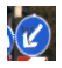

In [0]:
img_path = os.path.join('./train_and_valid_signs','test','00039','02050.ppm')
print(img_path)
img = image.load_img(img_path)
plt.figure(figsize=(1,1))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

In [10]:
sign_fnames = []
for ind in range(0,43):
  sign_fnames.append(os.listdir(os.path.join(base_dir,classes[ind])))  

print('00000 liczba obiektow: ',len(sign_fnames[0]))
print('00001 liczba obiektow: ',len(sign_fnames[1]))

00000 liczba obiektow:  151
00001 liczba obiektow:  1501


In [0]:
for i,fname in enumerate(sign_fnames):
  for j,name in enumerate(fname):
    if j<=0.9*int(np.floor(len(fname))):
      src = os.path.join(base_dir,classes[i],name)
      dst = os.path.join(dirs_train[i],name)
      shutil.copyfile(src,dst)
    if 0.9*int(np.floor(len(fname))) < j <= len(fname):
      src = os.path.join(base_dir,classes[i],name)
      dst = os.path.join(dirs_valid[i],name)
      shutil.copyfile(src,dst)

In [0]:
print('00000 zbior treningowy ',len(os.listdir(dirs_train[0])))
print('00000 zbior walidacyjny ',len(os.listdir(dirs_valid[0])))

print('00001 zbior treningowy ',len(os.listdir(dirs_train[1])))
print('00001 zbior walidacyjny ',len(os.listdir(dirs_valid[1])))

00000 zbior treningowy  136
00000 zbior walidacyjny  30
00001 zbior treningowy  1351
00001 zbior walidacyjny  300


#AUGMENTACJA DANYCH

In [12]:
train_datagen = ImageDataGenerator(
    rotation_range = 40,
    rescale = 1./255.,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

valid_datagen = ImageDataGenerator(rescale = 1./255.) #przeskalowanie danych

train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size=(32,32),
                                                    batch_size = 16,
                                                    class_mode='categorical')
valid_generator = train_datagen.flow_from_directory(directory = valid_dir,
                                                    target_size=(32,32),
                                                    batch_size = 16,
                                                    class_mode='categorical')

Found 23982 images belonging to 43 classes.
Found 2658 images belonging to 43 classes.


#TRANSFER LEARNING

In [0]:
conv_base = VGG16(weights = 'imagenet', include_top = False, input_shape=(32,32,3))
conv_base.trainable = False

def print_layers(model):
  for layer in model.layers:
    print(f'layer_name {layer.name:13} trainable: {layer.trainable}')

set_trainable = False
for layer in conv_base.layers:
  if layer.name =='block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

print_layers(conv_base)


layer_name input_7       trainable: False
layer_name block1_conv1  trainable: False
layer_name block1_conv2  trainable: False
layer_name block1_pool   trainable: False
layer_name block2_conv1  trainable: False
layer_name block2_conv2  trainable: False
layer_name block2_pool   trainable: False
layer_name block3_conv1  trainable: False
layer_name block3_conv2  trainable: False
layer_name block3_conv3  trainable: False
layer_name block3_pool   trainable: False
layer_name block4_conv1  trainable: False
layer_name block4_conv2  trainable: False
layer_name block4_conv3  trainable: False
layer_name block4_pool   trainable: False
layer_name block5_conv1  trainable: True
layer_name block5_conv2  trainable: True
layer_name block5_conv3  trainable: True
layer_name block5_pool   trainable: True


In [0]:
model = Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(units = 1024, activation = 'relu'))
model.add(layers.Dense(units = 43, activation = 'softmax'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dense_11 (Dense)             (None, 43)                44075     
Total params: 15,284,075
Trainable params: 569,387
Non-trainable params: 14,714,688
_________________________________________________________________


In [0]:
model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
history = model.fit_generator(generator=train_generator,
                              epochs = 50,
                              validation_data = valid_generator,
                              callbacks = [tensorboard])

#BUDOWA MODELU

In [13]:
model = Sequential()
model.add(layers.Conv2D(filters=32, kernel_size=(3,3),activation='relu',input_shape=(32, 32, 3)))
model.add(layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Conv2D(filters=256,kernel_size=(3,3),activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(units=2048, activation='relu'))
model.add(layers.Dense(units=43, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         295168    
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0

###50 epok RMS 
###20 epok adadelta

In [0]:
model.compile(optimizer = 'adadelta',  #optimizers.RMSprop(lr=1e-4), #
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
!rm -rf logs
!mkdir logs
tensorboard = TensorBoard(log_dir='logs')

In [19]:
history = model.fit_generator(generator=train_generator,
                              epochs = 50,
                              validation_data = valid_generator,
                              callbacks = [tensorboard])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1499 steps, validate for 167 steps
Epoch 1/50
1499/1499 [==============================] - 24s 16ms/step - loss: 0.1407 - accuracy: 0.9589 - val_loss: 0.1486 - val_accuracy: 0.9579
Epoch 2/50
1499/1499 [==============================] - 24s 16ms/step - loss: 0.1022 - accuracy: 0.9690 - val_loss: 0.1515 - val_accuracy: 0.9564
Epoch 3/50
1499/1499 [==============================] - 24s 16ms/step - loss: 0.0963 - accuracy: 0.9714 - val_loss: 0.1299 - val_accuracy: 0.9597
Epoch 4/50
1499/1499 [==============================] - 24s 16ms/step - loss: 0.0894 - accuracy: 0.9739 - val_loss: 0.1336 - val_accuracy: 0.9624
Epoch 5/50
1499/1499 [==============================] - 24s 16ms/step - loss: 0.0880 - accuracy: 0.9741 - val_loss: 0.1397 - val_accuracy: 0.9635
Epoch 6/50
1499/1499 [==============================] - 24s 16ms/step - loss: 0.0862 - accuracy: 0.9746 - val_loss: 0.1367 - val_accuracy: 0.9616
Epoch 7/50
1499/1499 [=======

In [20]:
%load_ext tensorboard
!tensorboard dev upload --logdir logs


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

logs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=los40zBinGo5Uzfv1gMsRyJ9lCxlC5&prompt=consent&access_type=offline
Enter th

#TEST SET

In [0]:
import csv

signs_classes = {}
file_name = ""
with open('./GT-final_test.csv', mode='r') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=';')
    line_count = 0
    for row in csv_reader:
      line_count += 1
      if 1 < line_count:
        signs_classes[row[0]] = row[7]

In [0]:
signs_test_names = []
signs_test_names.append(os.listdir('./GTSRB/Final_Test/Images'))

for j,name in enumerate(signs_test_names):
  for k,n in enumerate(name):
    src = os.path.join('./GTSRB/Final_Test/Images',n)
    dst = os.path.join(dirs_test[int(signs_classes[n])],n)
    shutil.copyfile(src,dst) 

In [23]:
test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_directory(
    './train_and_valid_signs/test/',
    target_size = (32,32),
    batch_size = 1,
    class_mode = 'categorical',
    shuffle = False
)

y_prob = model.predict_generator(test_generator, test_generator.samples)

Found 12630 images belonging to 43 classes.
Instructions for updating:
Please use Model.predict, which supports generators.


In [24]:
y_pred = np.argmax(y_prob,axis=1)
y_pred

array([ 1,  1,  1, ..., 42, 42, 42])

In [25]:
predictions = pd.DataFrame({'class':y_pred})
predictions

,class
0,1
1,1
2,1
3,0
4,1
...,...
12625,42
12626,42
12627,42
12628,42


In [26]:
y_true = test_generator.classes
y_true

array([ 0,  0,  0, ..., 42, 42, 42], dtype=int32)

In [43]:
cm = confusion_matrix(y_true,y_pred)
print(cm[39])

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  5  0  0  0  0 59 26  0  0  0]


In [29]:
print(classification_report(y_true,y_pred,target_names=test_generator.class_indices.keys()))

              precision    recall  f1-score   support

       00000       0.77      0.50      0.61        60
       00001       0.78      0.97      0.86       720
       00002       0.80      0.88      0.84       750
       00003       0.90      0.82      0.86       450
       00004       0.96      0.88      0.92       660
       00005       0.82      0.83      0.83       630
       00006       0.96      0.95      0.96       150
       00007       0.93      0.88      0.91       450
       00008       0.94      0.86      0.90       450
       00009       0.99      0.94      0.97       480
       00010       0.96      0.99      0.98       660
       00011       0.91      0.93      0.92       420
       00012       0.94      0.88      0.91       690
       00013       0.94      0.95      0.95       720
       00014       0.96      1.00      0.98       270
       00015       0.99      0.94      0.97       210
       00016       0.99      0.99      0.99       150
       00017       1.00    